In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.svm import SVR
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy import array
from numpy import hstack
from statsmodels.graphics.gofplots import qqplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import keras
import matplotlib
%matplotlib inline

### Ontario 34 HRs
### Label: Cumulative_cases 
- Train: model trained '2020-01-25' - '2020-06-30'
- Test: model test '2020-07-01' - '2020-07-26'

HR |  |  | 3551 | 3595 | 3553 | 3570 | 3530
--- | --- | --- | --- | --- | --- | --- | ---
HR | Data | ACC | ottawa | toronto | peel | york | durham
Train | Train | ACC |  |  |  |  | 
Test | Test | ACC |  | |  |  | 

### Quebec
### Label: Cumulative_cases
HR |  |  | 2406 | 2416 | 2413 | 2414 | 2415
--- | --- | --- | --- | --- | --- | --- | ---
HR | Data | ACC | montréal | montérégie | laval | lanaudière | laurentides
Train | Train | ACC |  |  |  |  | 
Test | Test | ACC |  | |  |  | 

In [40]:
## Run
## change label: df_merge_model = label('cumulative_cases')
## process data
conn = sqlite3.connect('../../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
df_health = pd.read_sql_query("SELECT * from Health_Indicators_ODHF", conn)
df_health1 = df_health[['HR_UID','Population_density', 'ambulatory','hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']]
mob_health = pd.merge(df_mob, df_health1, how='left', on=['HR_UID'])
df_COVID = pd.read_sql_query("SELECT * from Covid19", conn)
# total cols of 2 dataframe merged
new = df_COVID['HR_UID'].str.split(".", n = 1, expand = True) 
df_COVID['HR_UID']= new[0]
pd_merge = pd.merge(mob_health, df_COVID, how='right', left_on=['DATE', 'HR_UID'], right_on=['report_date', 'HR_UID'])
# mob_health date '2020-07-05'
max_date = mob_health['DATE'].max()
max_date1 = df_COVID['report_date'].max()
if max_date<max_date1:
    max_dt = max_date
else:
    max_dt= max_date1
pd_merge_new = pd_merge.loc[(pd_merge['DATE']>='2020-01-25') & (pd_merge['DATE']<=max_dt)]
# dropping duplicte values on same HR_UID and Date
pd_merge_new.drop_duplicates(subset =["HR_UID", "DATE"], inplace = True) 
# add label to df
df_risk_label = pd.read_sql_query("SELECT * from HIGH_RISK_20", conn)
df_risk_label_la = df_risk_label.rename(columns={"cases": "cases_la", "cumulative_cases": "cumulative_cases_la",
                             "deaths":"deaths_la", "cumulative_deaths":"cumulative_deaths_la"})
pd_merge_label = pd.merge(pd_merge_new, df_risk_label_la, on=['report_date', 'HR_UID'], how='left')
# minmax scaler
scaler = MinMaxScaler()
# minmax scaler
scaler1 = MinMaxScaler()
# add and remove cumulative_deaths, cumulative_cases
def label(label):
    lst = ['Md_PD', 'Mrr_PD',
        'Mgp_PD', 'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD',
        'Mrr_MD', 'Mgp_MD', 'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD','Md_RP', 'Mrr_RP',
       'Mgp_RP', 'Mp_RP', 'Mt_RP', 'Mw_RP', 'Mr_RP', 'M_RP', 'Md_MP', 'Mrr_MP',
       'Mgp_MP', 'Mp_MP', 'Mt_MP', 'Mw_MP', 'Mr_MP', 'M_MP','cases', 'cumulative_cases', 'deaths',
       'cumulative_deaths', 'Population_density','ambulatory','hospitals','nursing_residential']
#     lst.remove(label)
    data = pd_merge_label[lst]

    data1 = pd_merge_label[[label]]
    data_scale = scaler.fit_transform(data)
#     data_scale1 = scaler1.fit_transform(data1)
    df_data_scale = pd.DataFrame(data=data_scale,columns=lst)
#     df_data_scale1 = pd.DataFrame(data=data_scale1,columns=[label])
    col_lst = list(set(pd_merge_label.columns.tolist()) - set(df_data_scale.columns.tolist())- set(data1.columns.tolist()))
    col_lst.append('PRUID_x')
    pd_feature = pd_merge_label[col_lst]
    pd_feature.reset_index(inplace=True)
    df_merge_model = pd.concat([pd_feature, df_data_scale, data1], axis=1)
    return df_merge_model

df_merge_model = label('cumulative_cases_la')
df_merge_model.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


index  deaths_la     PROV report_date PRUID_x                    HR_NAME  \
0      0        0.0  Ontario  2020-01-25      35  Peel Regional Health Unit   
1      1        0.0  Ontario  2020-01-26      35  Peel Regional Health Unit   
2      2        0.0  Ontario  2020-01-27      35  Peel Regional Health Unit   
3      3        0.0  Ontario  2020-01-28      35  Peel Regional Health Unit   
4      4        0.0  Ontario  2020-01-29      35  Peel Regional Health Unit   

   Perceived_health_poor health_region  Perceived_health_good  \
0                  0.106          peel                  0.577   
1                  0.106          peel                  0.577   
2                  0.106          peel                  0.577   
3                  0.106          peel                  0.577   
4                  0.106          peel                  0.577   

   cumulative_deaths_la  ...      M_MP cases  cumulative_cases deaths  \
0                   0.0  ...  0.621375   0.0               0.0    0.0   
1                   0.0  ...  0.433864   0.0               0.0    0.0   
2                   0.0  ...  0.511814   0.0               0.0    0.0   
3                   0.0  ...  0.550314   0.0               0.0    0.0   
4                   0.0  ...  0.568802   0.0               0.0    0.0   

  cumulative_deaths  Population_density  ambulatory  hospitals  \
0               0.0            0.255652         1.0   0.714286   
1               0.0            0.255652         1.0   0.714286   
2               0.0            0.255652         1.0   0.714286   
3               0.0            0.255652         1.0   0.714286   
4               0.0            0.255652         1.0   0.714286   

   nursing_residential  cumulative_cases_la  
0                  1.0                  0.0  
1                  1.0                  0.0  
2                  1.0                  0.0  
3                  1.0                  0.0  
4                  1.0                  0.0  

[5 rows x 56 columns]

In [88]:
df_merge_model['report_date'].max()

Timestamp('2020-08-28 00:00:00')

## Model Input for Multiple Input Series
-  first dimension is the number of samples
-  second dimension is the number of time steps per sample
-  the last dimension specifies the number of parallel time series or the number of variables

## Multivariate model
- label: Cum_deaths
    - lag features: 5 days
- label: Cum_cases
    - lag features: 5 days
    
- ON
    - 34 pandemic hubs
- approach
    - first
    - get independent HR df and train test split by 0.8 and 0.2, (by time-series factor), take time into account
    - concat array for X_train, and X_test

In [41]:
## Run
## change the label df_label = df_hr[['cumulative_cases_x']]
## change time_lag features
# # shift the value upward
df_merge_model['report_date'] = pd.to_datetime(df_merge_model['report_date'])
# df1 = df.set_index('DATE')
df_new = df_merge_model[['HR_UID', 'report_date','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP', 'report_date']]

def shift_df(lst, lag_date):
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            val = -lag_date_run
            df_new[col_name] = df_new.groupby(['HR_UID'])[a].shift(val)
    return df_new

df_new1 = shift_df(['HR_UID','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP'],5)
# remove null row
df_new1.dropna(inplace=True)
# drop duplicated columns
df_new2 = df_new1.loc[:,~df_new1.columns.duplicated()]

## Merge df back with health indicator
df_new3 = pd.merge(df_merge_model, df_new2, how='left', on=['HR_UID','report_date'])
# remove null row
df_new3.dropna(inplace=True)
# drop duplicated columns
df_new4 = df_new3.loc[:,~df_new3.columns.duplicated()]
# df_on = df_new4.loc[df_new4['PRUID_x']==str(35)]

df_dum_HR = pd.get_dummies(df_new4.HR_UID, prefix='HR_UID')
df_hr_dum = pd.concat([df_new4, df_dum_HR], axis=1)

# select one hr
def df_filter(hr, case, lag_date):
    df_hr = df_hr_dum.loc[df_hr_dum['HR_UID']==str(hr)]
    # list for input lagged features
    lst = ['cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP']
    col_lst = []
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            col_lst.append(col_name)
            
    lst1 = ['Mt_RP_x', 'Mt_MP_x', 'Mw_MD_x', 'Mgp_RP_x', 'Population_density','ambulatory',
               'hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']
    col_lst+=lst1
    col_lst+=df_dum_HR.columns.tolist()
    
    if case:
        col_lst.append('cases_x')
    df_feature = df_hr[col_lst]
    df_label = df_hr[['cumulative_cases_la']]
    # drop duplicated columns
    df_hr1 = df_hr.loc[:,~df_hr.columns.duplicated()]
   
    return df_feature, df_label, df_hr1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [42]:
## Run
# split_sequences to change the dimensions of input
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []
X_val_lst = []
y_val_lst = []

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, label_seq):
    label_seq = label_seq.reshape(label_seq.shape[0], -1)
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], label_seq[end_ix-1, :]
#         seq_x = sequences[i:end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y).reshape(-1)

for hr in df_hr_dum['HR_UID'].unique().tolist():
    
    feature_train, label_train, df_hr1 = df_filter(hr, True,5)
    # loc train date till Jun/30, test: July
    X_train = feature_train.iloc[:189, :]
    X_test = feature_train.iloc[189:, :]
    y_train = label_train.iloc[:189, :]
    y_test = feature_train.iloc[189:, :]
#     X_train, X_test, y_train, y_test = train_test_split(
#                          feature_train, label_train, test_size=0.2, random_state=42, shuffle=False)
    
    # train data
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    X_train_lst.append(X_train_3d)
    X_test_lst.append(X_test_3d)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)
    # X_train shape (124, 101)
    # val data
#     Y_val = label_val.to_numpy().reshape(-1,)
#     X_val_3d, y_val = split_sequences(feature_val.to_numpy(), 2, Y_val)
#     X_val_lst.append(X_val_3d)
#     y_val_lst.append(y_val)
    
    
X_train = np.concatenate(X_train_lst, axis=0)
# X_train.shape (4182, 2, 101)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
# Y_train.shape (4182,)
y_test = np.concatenate(y_test_lst, axis=0)

# X_val = np.concatenate(X_val_lst, axis=0)
# y_val = np.concatenate(y_val_lst, axis=0)

Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)
# Y_val = y_val.reshape(-1,)
Y_train.shape


(20034,)

In [43]:
## Run

n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape

# (108, 1,  11)

(20034, 1, 157)

In [35]:
def lstm(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))
    return history, model

In [36]:
def lstm_2layer(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features), return_sequences=True))
    model.add(LSTM(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))
    return history, model

### Label Cumulative Cases

In [37]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_90_2, model_90_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80_2, model_80_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60_2, model_60_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)

Train on 20034 samples, validate on 2432 samples
Epoch 1/50
 - 15s - loss: 0.3358 - accuracy: 0.8662 - val_loss: 1.2506 - val_accuracy: 0.2833
Epoch 2/50
 - 7s - loss: 0.2551 - accuracy: 0.8968 - val_loss: 1.3602 - val_accuracy: 0.2697
Epoch 3/50
 - 9s - loss: 0.2466 - accuracy: 0.8994 - val_loss: 1.4226 - val_accuracy: 0.2751
Epoch 4/50
 - 7s - loss: 0.2347 - accuracy: 0.9032 - val_loss: 1.6312 - val_accuracy: 0.2800
Epoch 5/50
 - 10s - loss: 0.2225 - accuracy: 0.9081 - val_loss: 2.1231 - val_accuracy: 0.2775
Epoch 6/50
 - 8s - loss: 0.2154 - accuracy: 0.9113 - val_loss: 2.2839 - val_accuracy: 0.2775
Epoch 7/50
 - 7s - loss: 0.2094 - accuracy: 0.9140 - val_loss: 2.5017 - val_accuracy: 0.2808
Epoch 8/50
 - 8s - loss: 0.2052 - accuracy: 0.9166 - val_loss: 2.8592 - val_accuracy: 0.2775
Epoch 9/50
 - 9s - loss: 0.2010 - accuracy: 0.9188 - val_loss: 3.0995 - val_accuracy: 0.2763
Epoch 10/50
 - 7s - loss: 0.1968 - accuracy: 0.9198 - val_loss: 3.2979 - val_accuracy: 0.2775
Epoch 11/50
 - 6s 

## Save & load model

In [38]:
model_90.save("classify_mdl/new/lstm_mdel90_20")
model_80.save("classify_mdl/new/lstm_mdel80_20")
model_60.save("classify_mdl/new/lstm_mdel60_20")
model_50.save("classify_mdl/new/lstm_mdel50_20")
model_90_2.save("classify_mdl/new/lstm_mdel902_20")
model_80_2.save("classify_mdl/new/lstm_mdel802_20")
model_60_2.save("classify_mdl/new/lstm_mdel602_20")


In [44]:
model_90 = keras.models.load_model("classify_mdl/new/lstm_mdel90_20")
model_80= keras.models.load_model("classify_mdl/new/lstm_mdel80_20")
model_60= keras.models.load_model("classify_mdl/new/lstm_mdel60_20")
model_50= keras.models.load_model("classify_mdl/new/lstm_mdel50_20")
model_90_2= keras.models.load_model("classify_mdl/new/lstm_mdel902_20")
model_80_2= keras.models.load_model("classify_mdl/new/lstm_mdel802_20")
model_60_2= keras.models.load_model("classify_mdl/new/lstm_mdel602_20")


In [9]:
# model_80_2 = keras.models.load_model("classify_mdl/lstm_mdel602_20")
model_80_2 = keras.models.load_model("lstm_mdel15")

## 1 Layer LSTM model

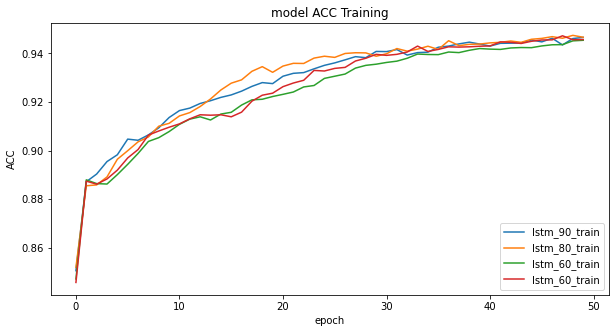

In [14]:
# with lagged 5 features
# 1D
plt.figure(figsize=(10, 5))

plt.plot(history_90.history['accuracy'])
plt.plot(history_80.history['accuracy'])
plt.plot(history_60.history['accuracy'])
plt.plot(history_50.history['accuracy'])


plt.title('model ACC Training')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_train', 'lstm_80_train', 'lstm_60_train', 'lstm_60_train'], loc='lower right')
plt.show()

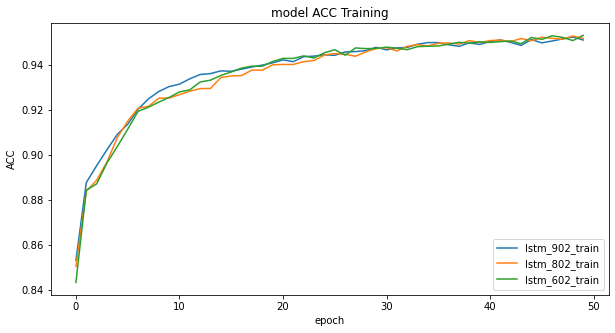

In [15]:
# with lagged 5 features
# 1D
plt.figure(figsize=(10, 5))

plt.plot(history_90_2.history['accuracy'])
plt.plot(history_80_2.history['accuracy'])
plt.plot(history_60_2.history['accuracy'])
# plt.plot(history_50.history['accuracy'])


plt.title('model ACC Training')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_902_train', 'lstm_802_train', 'lstm_602_train'], loc='lower right')
plt.show()

## 2 Layer LSTM model

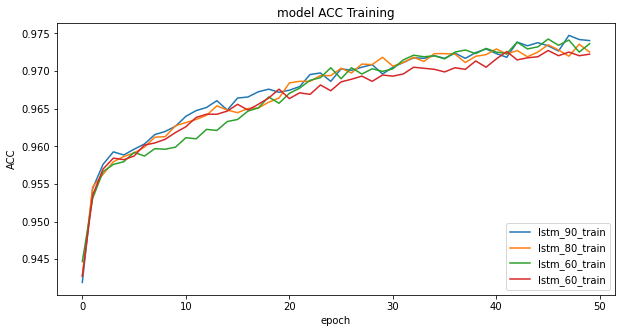

In [48]:
# with lagged 5 features
# 2D
plt.figure(figsize=(10, 5))

plt.plot(history_90.history['accuracy'])
plt.plot(history_80.history['accuracy'])
plt.plot(history_60.history['accuracy'])
plt.plot(history_50.history['accuracy'])


plt.title('model ACC Training')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_train', 'lstm_80_train', 'lstm_60_train', 'lstm_60_train'], loc='lower right')
plt.show()

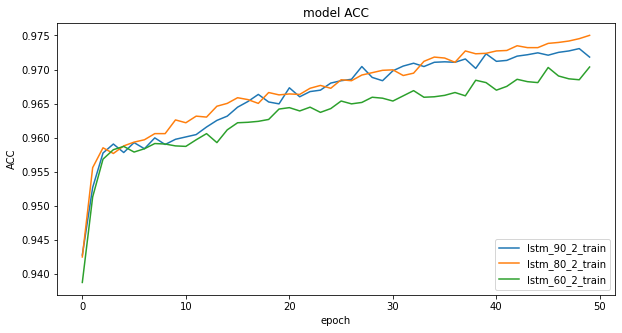

In [49]:
# with lagged 5 features
# 2D
plt.figure(figsize=(10, 5))

plt.plot(history_90_2.history['accuracy'])
plt.plot(history_80_2.history['accuracy'])
plt.plot(history_60_2.history['accuracy'])

plt.title('model ACC')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='lower right')

plt.show()

## 3 Layer LSTM model

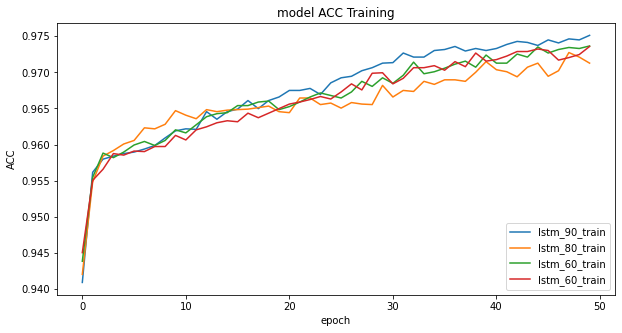

In [103]:
# with lagged 5 features
# 2D
plt.figure(figsize=(10, 5))

plt.plot(history_90.history['accuracy'])
plt.plot(history_80.history['accuracy'])
plt.plot(history_60.history['accuracy'])
plt.plot(history_50.history['accuracy'])


plt.title('model ACC Training')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_train', 'lstm_80_train', 'lstm_60_train', 'lstm_60_train'], loc='lower right')
plt.show()

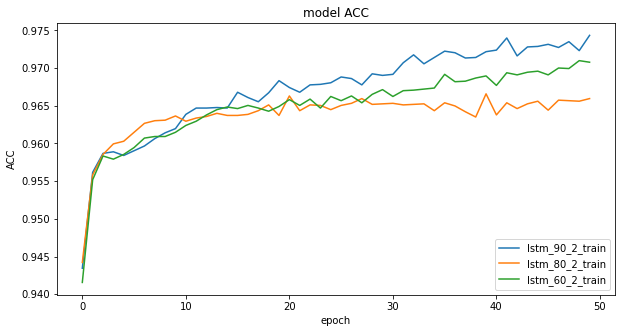

In [104]:
# with lagged 5 features
# 2D
plt.figure(figsize=(10, 5))

plt.plot(history_90_2.history['accuracy'])
plt.plot(history_80_2.history['accuracy'])
plt.plot(history_60_2.history['accuracy'])

plt.title('model ACC')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='lower right')

plt.show()

## Locate the pandemic hub (one)

In [46]:
feature_train, label_train, df_hr1 = df_filter('2415', True,5)
X_train = feature_train.iloc[:158, :]
X_test = feature_train.iloc[158:, :]
y_train = label_train.iloc[:158, :]
y_test = label_train.iloc[158:, :]



# X_train, X_test, y_train, y_test = train_test_split(
#                      feature_train, label_train, test_size=0.2, random_state=42, shuffle=False)

# train data
Y_train = y_train.to_numpy().reshape(-1,)
Y_test = y_test.to_numpy().reshape(-1,)
X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)

n_sample = 1
n_step = X_train_3d.shape[0]
n_features = X_train_3d.shape[-1]
x_train = X_train_3d.reshape(n_step, -1,n_features)
x_test = X_test_3d.reshape(X_test_3d.shape[0], -1,n_features)

train_pred_90 = model_80_2.predict_classes(x_train).flatten()
test_pred_90 = model_80_2.predict_classes(x_test).flatten()

print('ACC score on train:', accuracy_score(train_pred_90, y_train))
print('ACC score on test:', accuracy_score(test_pred_90, y_test))
print('F1 Score: ', f1_score(train_pred_90, y_train))

ACC score on train: 0.9430379746835443
ACC score on test: 1.0
F1 Score:  0.9485714285714286


## Locate ON pandemic hub

In [84]:
# Get the avg pred score on each HR
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []

df_on = df_hr_dum.loc[df_hr_dum['PRUID_x']==str(60)]
on_hr = df_on['HR_UID'].unique().tolist()
# on_hr = df_hr_dum['HR_UID'].unique().tolist()
for hr in on_hr:
    df_feature, df_label, df_hr1 = df_filter(hr, True,5)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    X_train_lst.append(X_train_3d)
    X_test_lst.append(X_test_3d)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)

    
X_train = np.concatenate(X_train_lst, axis=0)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
y_test = np.concatenate(y_test_lst, axis=0)


Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)
Y_train.shape

(164,)

In [85]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape

(164, 1, 157)

In [86]:
train_pred_90 = model_80_2.predict_classes(x_train).flatten()
test_pred_90 = model_80_2.predict_classes(x_test).flatten()
print('ACC score on train:', accuracy_score(train_pred_90, Y_train))
print('ACC score on test:', accuracy_score(test_pred_90, Y_test))

ACC score on train: 1.0
ACC score on test: 1.0


In [58]:
# Dim1
print(classification_report(train_pred_90, Y_train))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4936
           1       0.56      0.44      0.49        62

    accuracy                           0.99      4998
   macro avg       0.78      0.72      0.74      4998
weighted avg       0.99      0.99      0.99      4998



## Locate QC pandemic hub

In [66]:
# Get the avg pred score on each HR
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []

df_qc = df_hr_dum.loc[df_hr_dum['PRUID_x']==str(24)]
qc_hr = df_qc['HR_UID'].unique().tolist()
for hr in qc_hr:
    df_feature, df_label, df_hr1 = df_filter(hr, True,5)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    X_train_lst.append(X_train_3d)
    X_test_lst.append(X_test_3d)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)

    
X_train = np.concatenate(X_train_lst, axis=0)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
y_test = np.concatenate(y_test_lst, axis=0)


Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)
Y_train.shape

(2646,)

In [67]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape

(2646, 1, 157)

In [68]:

train_pred_90 = model_80_2.predict_classes(x_train).flatten()
test_pred_90 = model_80_2.predict_classes(x_test).flatten()
print('ACC score on train:', accuracy_score(train_pred_90, Y_train))
print('ACC score on test:', accuracy_score(test_pred_90, Y_test))

ACC score on train: 0.999244142101285
ACC score on test: 1.0


In [69]:
# Dim1
print(classification_report(train_pred_90, Y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2418
           1       0.99      1.00      1.00       228

    accuracy                           1.00      2646
   macro avg       1.00      1.00      1.00      2646
weighted avg       1.00      1.00      1.00      2646



### Locate ALL CA pandemic hub

In [70]:
# Get the avg pred score on each HR
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []

# df_qc = df_hr_dum.loc[df_hr_dum['PRUID_x']==str(24)]
qc_hr = df_hr_dum['HR_UID'].unique().tolist()
for hr in qc_hr:
    df_feature, df_label, df_hr1 = df_filter(hr, True,5)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    X_train_lst.append(X_train_3d)
    X_test_lst.append(X_test_3d)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)

    
X_train = np.concatenate(X_train_lst, axis=0)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
y_test = np.concatenate(y_test_lst, axis=0)


Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)
Y_train.shape

(15578,)

In [71]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape

(15578, 1, 157)

In [72]:
train_pred_90 = model_80_2.predict_classes(x_train).flatten()
test_pred_90 = model_80_2.predict_classes(x_test).flatten()
print('ACC score on train:', accuracy_score(train_pred_90, Y_train))
print('ACC score on test:', accuracy_score(test_pred_90, Y_test))

ACC score on train: 0.9720760046219027
ACC score on test: 0.9719459321601632


In [73]:
# Dim1
print(classification_report(train_pred_90, Y_train))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     14842
           1       0.65      0.87      0.75       736

    accuracy                           0.97     15578
   macro avg       0.82      0.93      0.87     15578
weighted avg       0.98      0.97      0.97     15578



In [224]:
# Dim1
print(classification_report(test_pred_90, Y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3241
           1       0.96      0.74      0.84       256

    accuracy                           0.98      3497
   macro avg       0.97      0.87      0.91      3497
weighted avg       0.98      0.98      0.98      3497

